In [1]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dimension reduction and clustering libraries
%pip install umap-learn
import umap
%pip install hdbscan
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Load in the test data.

In [2]:
sub1test = np.load("/Users/shruti/Desktop/finalproj/n120/sub-001_Resp_Test.npy")
sub2test = np.load("/Users/shruti/Desktop/finalproj/n120/sub-002_Resp_Test.npy")
sub3test = np.load("/Users/shruti/Desktop/finalproj/n120/sub-003_Resp_Test.npy")
sub4test = np.load("/Users/shruti/Desktop/finalproj/n120/sub-004_Resp_Test.npy")
sub5test = np.load("/Users/shruti/Desktop/finalproj/n120/sub-005_Resp_Test.npy")
print(sub1test.shape)
print(sub2test.shape)
print(sub3test.shape)
print(sub4test.shape)
print(sub5test.shape)

(60784, 4, 600)
(53927, 4, 600)
(64700, 4, 600)
(61899, 4, 600)
(53421, 4, 600)


Concatenate all of the data.

In [3]:
# Each element should be a NumPy array of shape [n_voxels, 4, 60]
subject_list = [sub1test, sub2test, sub3test, sub4test, sub5test]

In [4]:
all_subjects_data = []       # list of [240, n_voxels] per subject
all_genre_labels = []        # genre_labels_named per subject
all_subject_ids = []         # subject index per sample

Create a genre label vector to feed into the UMAP function.

In [ ]:
import scipy.io as sio
import numpy as np

# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/shruti/Desktop/finalproj/n120/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

# Step 1: Extract the genre label for each of the 60 tracks (6 runs × 10 tracks)
# We use repetition 0 because all 4 reps use the same tracks
genre_labels = []

for run in range(6):  # 6 runs
    for track_position in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_position])  # genre labels are 1-indexed (1–10)
        genre_labels.append(genre_id)

# Step 2: Repeat each genre label 4 times (one for each repetition)
genre_labels_full = np.repeat(genre_labels, 4)  # shape: (240,)

In [ ]:
# Load the .mat file (adjust the path if needed)
data = sio.loadmat('/Users/shruti/Desktop/finalproj/n120/AcrossGenre_Order_Test.mat')
test_run_data = data['across_genre_rn_test']  # shape: (6 runs, 4 reps, 10 genres)

#Extract numeric genre IDs
genre_labels = []
for run in range(6):  # 6 runs
    for track_pos in range(10):  # 10 tracks per run
        genre_id = int(test_run_data[run, 0, track_pos])
        genre_labels.append(genre_id)  # values: 1–10

#Repeat each genre label 3 times (for 3 reps), for subect-level analysis
genre_labels_full = np.repeat(genre_labels, 3) # shape: (180,)

#Repeat for 5 subjects, for cross-subject
genre_labels_full_all = np.tile(genre_labels_full, 5)  # shape: (900,)

#Convert to names using the corrected mapping
genre_names = [
    'country',    # index 1
    'reggae',     # index 2
    'rock',       # index 3
    'blues',      # index 4
    'classical',  # index 5
    'hiphop',     # index 6
    'disco',      # index 7
    'jazz',       # index 8
    'metal',      # index 9
    'pop'         # index 10
]

# Create labeled vectors
genre_labels_named_180 = [genre_names[i - 1] for i in genre_labels_full] 
genre_labels_named_900 = [genre_names[i - 1] for i in genre_labels_full_all]


FULL PROCESS:
Preprocesses sub1test (180 trials), reshaping data to time series vectors.
Extracts genre-responsive voxels using ANOVA.
Runs PCA to 100 components.
Runs UMAP to reduce to 2D.
Plots the result, color-coded by genre.

In [ ]:
def preprocess_subject(fmri_data, reps_to_use=3, timepoints_per_track=10):
    """
    Preprocess fMRI data for one subject, without averaging across repetitions.
    """
    n_voxels = fmri_data.shape[0]
    
    reshaped = np.transpose(
        fmri_data[:, :reps_to_use, :].reshape(n_voxels, reps_to_use, 60, timepoints_per_track),
        (0, 3, 2, 1)
    ).reshape(n_voxels * timepoints_per_track, 60 * reps_to_use)

    X = reshaped.T  # shape: (180 samples, n_voxels * timepoints)
    X_voxel_time = X.reshape(180, n_voxels, timepoints_per_track)
    X_mean_time = np.mean(X_voxel_time, axis=2)  # shape: (180 samples, n_voxels)

    return X_mean_time

MASKING: Filter fMRI data so there is less noise by choosing for the voxels that have auditory response. We are looking at the variance of voxel activity, and selecting from there. We will be doing a match test with masking so voxels match up against subject.

In [ ]:
from scipy.stats import f_oneway

def extract_genre_responsive_voxels(data_matrix, genre_labels = genre_labels_named_180, alpha=0.05):
    """
    Performs voxel-wise one-way ANOVA across genres and selects significant voxels.
    """
    genre_labels = np.array(genre_labels)
    unique_genres = np.unique(genre_labels)

    p_values = []
    for voxel_idx in range(data_matrix.shape[1]):
        voxel_data = data_matrix[:, voxel_idx]
        grouped_data = [voxel_data[genre_labels == genre] for genre in unique_genres]
        f_stat, p_val = f_oneway(*grouped_data)
        p_values.append(p_val)

    p_values = np.array(p_values)
    functional_roi_mask = p_values < alpha
    data_matrix_roi = data_matrix[:, functional_roi_mask]

    return data_matrix_roi, functional_roi_mask, p_values

In [ ]:
data_matrix = preprocess_subject(sub1test) 
data_matrix_roi, roi_mask, pvals = extract_genre_responsive_voxels(data_matrix)
print("ROI-filtered shape:", data_matrix_roi.shape)

ROI-filtered shape: (180, 4646)


/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


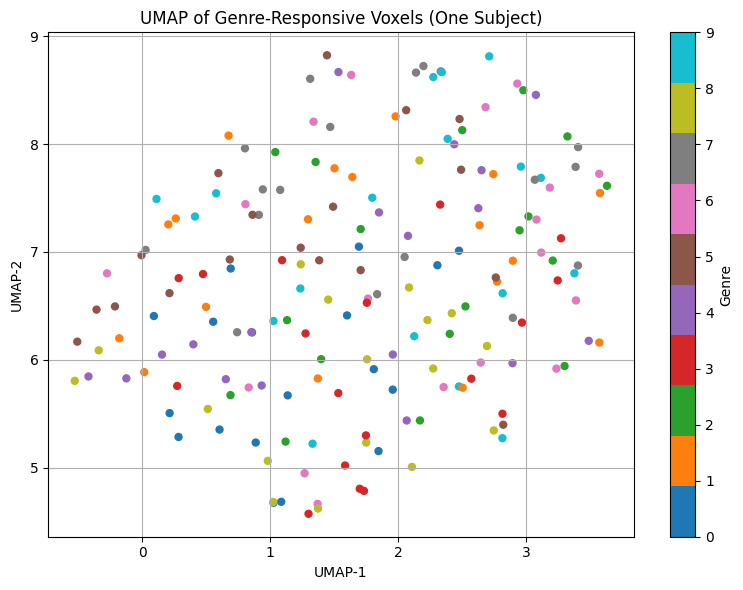

In [ ]:
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
#PCA
pca = PCA(n_components=100)
roi_data_pca = pca.fit_transform(data_matrix_roi)

#UMAP
reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=2, random_state=42)
embedding = reducer.fit_transform(roi_data_pca)

#Plot UMAP, colored by genre
genre_encoder = LabelEncoder()
genre_encoded = genre_encoder.fit_transform(genre_labels_named_180)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=genre_encoded, cmap='tab10', s=25)
plt.title("UMAP of Genre-Responsive Voxels (One Subject)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(ticks=range(len(np.unique(genre_encoded))), label='Genre')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(embedding, genre_encoded)
print(f"Silhouette score by genre: {score:.3f}")
 
#quantify unsupervised cluster quality, goes from -1 to +1 (negative indicates ploor clustering)

Silhouette score by genre: -0.169


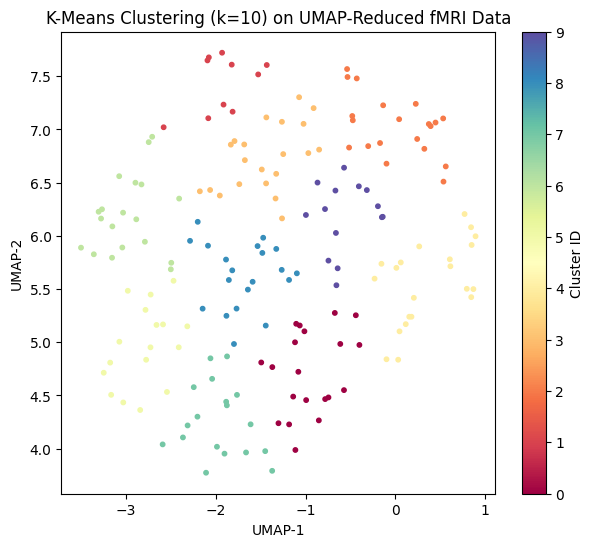

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Run KMeans on your UMAP embedding (2D)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(embedding)  # embedding: [n_samples, 2]

# Step 2: Visualize clusters
plt.figure(figsize=(7, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans_labels, cmap='Spectral', s=10)
plt.title("K-Means Clustering (k=10) on UMAP-Reduced fMRI Data")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label="Cluster ID")
plt.show()
